# Galaxies vs quasars with neural networks

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
gal_qso = pd.read_csv("galaxyquasar.csv")

In [5]:
gal_qso

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

In [7]:
u_g = gal_qso['u']-gal_qso['g']
g_r = gal_qso['g']-gal_qso['r']
r_i = gal_qso['r']-gal_qso['i']
i_z = gal_qso['i']-gal_qso['z']
objclass = gal_qso['class']
objclass.replace({'GALAXY': 0, 'QSO': 1}, inplace=True)

labels = ['u - g', 'g - r', 'r - i', 'i - z']

In [8]:
datanormed = np.zeros((len(gal_qso), 5), dtype=np.float32)
datanormed[:,0] = u_g
datanormed[:,1] = g_r
datanormed[:,2] = r_i
datanormed[:,3] = i_z
datanormed[:,4] = objclass

for i in range(4):
    datanormed[:, i] = (datanormed[:,i] - datanormed[:,i].mean()) / datanormed[:,i].std()     # standardization

datanormed

array([[-1.6009288 , -2.1856372 , -0.50654745, -0.6597535 ,  1.        ],
       [ 0.8389048 ,  1.187664  ,  0.41731444,  0.47661117,  0.        ],
       [ 0.7716402 ,  0.5052708 , -0.04953586, -0.14751524,  0.        ],
       ...,
       [ 0.01402617, -0.6316634 , -0.4313488 , -0.11315826,  0.        ],
       [-0.06668057,  0.08235241,  0.26991966, -0.17028053,  0.        ],
       [-0.47648638, -0.8982767 , -0.7141288 , -0.5216415 ,  0.        ]],
      dtype=float32)

In [13]:
# split data into 7:3 train:test
dataset = torchdata.TensorDataset(torch.tensor(datanormed[:, 0:4]),
                                  torch.tensor(datanormed[:, 4]).view(-1, 1))
trainnum = datanormed.shape[0] // 10 * 7
traindata, testdata = torchdata.random_split(dataset, 
                                             [trainnum, datanormed.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, 
                                       batch_size=128, 
                                       shuffle=True)

In [32]:
class Net(nn.Module):
    def __init__(self, nhidden):
        super(Net, self).__init__()
        self.fc_h = nn.Linear(4, nhidden)  
        self.fc_o = nn.Linear(nhidden, 1)  

    def forward(self, x):
        x = F.relu(self.fc_h(x))      # ReLU activation function
        x = self.fc_o(x)  
        return x

def train_NN(traindataloader, testdata, traindata):
    model = Net(5)                                     # number of neurons: 5
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        # adam solver

    for t in range(100):
        model.train()
        train_loss = 0
        for colors, labels in traindataloader:
            optimizer.zero_grad()
            logits = model(colors)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_logits = model(testdata[:][0])
            val_labels = testdata[:][1]
            val_loss = criterion(val_logits, val_labels)

        if t % 10 == 0:
            print(f"Epoch {t:3d}: Train loss {train_loss / len(traindata):.4f}  Val loss {val_loss / len(testdata):.4f}")

    return model


In [33]:
model = train_NN(traindataloader, testdata, traindata)

Epoch   0: Train loss 0.0046  Val loss 0.0000
Epoch  10: Train loss 0.0006  Val loss 0.0000
Epoch  20: Train loss 0.0005  Val loss 0.0000
Epoch  30: Train loss 0.0005  Val loss 0.0000
Epoch  40: Train loss 0.0005  Val loss 0.0000
Epoch  50: Train loss 0.0005  Val loss 0.0000
Epoch  60: Train loss 0.0005  Val loss 0.0000
Epoch  70: Train loss 0.0005  Val loss 0.0000
Epoch  80: Train loss 0.0005  Val loss 0.0000
Epoch  90: Train loss 0.0005  Val loss 0.0000


In [34]:
print(model)

Net(
  (fc_h): Linear(in_features=4, out_features=5, bias=True)
  (fc_o): Linear(in_features=5, out_features=1, bias=True)
)


### ROC curve

In [35]:
X_train = traindata[:][0].numpy().squeeze()
y_train = traindata[:][1].numpy().squeeze()
X_test = testdata[:][0]
y_test = testdata[:][1].numpy().squeeze()

thresholds = np.linspace(0, 1, 1001)[:-1]

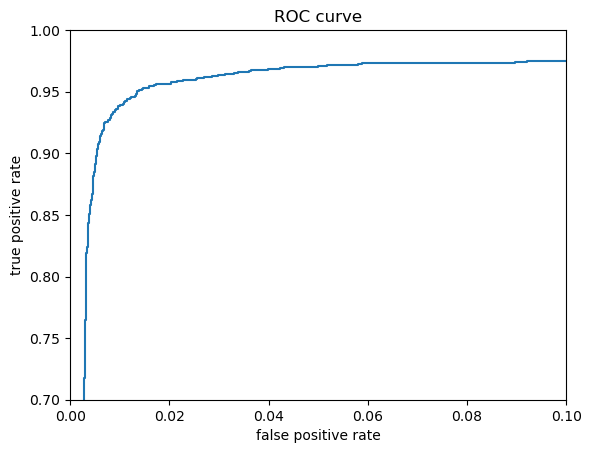

In [36]:
from sklearn.metrics import roc_curve
    
with torch.no_grad():
    logits = model(X_test)
    y_prob = torch.sigmoid(logits).numpy().flatten()
    
fpr, tpr, thresh = roc_curve(y_test, y_prob)

fig = plt.figure()
ax1 = plt.subplot()

ax1.plot(fpr, tpr)

ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('ROC curve')
ax1.set_xlim(0,0.1)
ax1.set_ylim(0.7,1)

plt.show()

### Comparison with other classification methods

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes

clf = LDA()
clf.fit(X_train, y_train)
probLDA = clf.predict_proba(X_test)[:,1]
for i, t in enumerate(thresholds):
    y_pred = (probLDA >= t)
    
clf = QDA()
clf.fit(X_train, y_train)
probQDA = clf.predict_proba(X_test)[:,1]
for i, t in enumerate(thresholds):
    y_pred = (probQDA >= t)
    
clf = GMMBayes(5, tol=1E-5, covariance_type='full')
clf.fit(X_train, y_train)
probGMM = clf.predict_proba(X_test)[:,1]
for i, t in enumerate(thresholds):
    y_pred = (probGMM >= t)

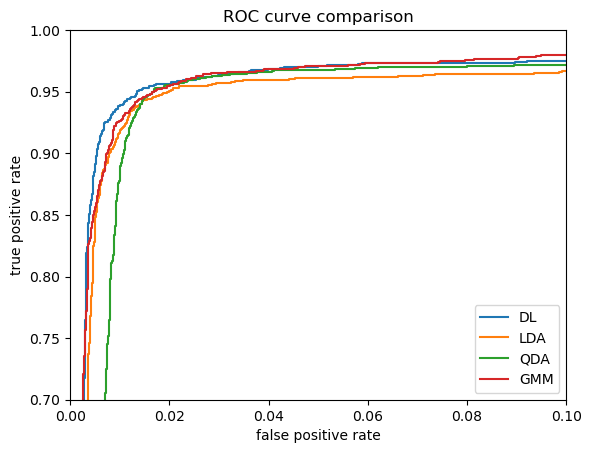

In [38]:
# Plot ROC curves 

fig = plt.figure()
ax1 = plt.subplot()

fpr, tpr, thresh = roc_curve(y_test, y_prob)
ax1.plot(fpr, tpr, label='DL')

fpr, tpr, thresh = roc_curve(y_test, probLDA)
ax1.plot(fpr, tpr, label='LDA')

fpr, tpr, thresh = roc_curve(y_test, probQDA)
ax1.plot(fpr, tpr, label='QDA')

fpr, tpr, thresh = roc_curve(y_test, probGMM)
ax1.plot(fpr, tpr, label='GMM')

ax1.set_xlim(0, 0.1)
ax1.set_ylim(0.7, 1)

ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('ROC curve comparison')
ax1.legend(loc=4)

plt.show()

Very similar behaviour, no need for deep learning for this problem.

### Optimization of hyperparameters

In [39]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from skorch import NeuralNetBinaryClassifier

In [40]:
class Net(nn.Module):
    def __init__(self, nhidden, nlayers):
        super().__init__()
        layers = [nn.Linear(4, nhidden), nn.ReLU()]
        for _ in range(nlayers - 1):
            layers += [nn.Linear(nhidden, nhidden), nn.ReLU()]
        layers += [nn.Linear(nhidden, 1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [41]:
net = NeuralNetBinaryClassifier(
    Net,
    module__nhidden=5,
    max_epochs=20,
    lr=0.001,
    iterator_train__shuffle=True,
    verbose=0
)

Nlim = 1000
X = X_train[:Nlim]
y = y_train[:Nlim]

# Grid Search
params = {
    'lr': [0.01, 0.001, 0.0001],
    'max_epochs': [10, 20],
    'module__nhidden': [2, 5, 10],
    'module__nlayers': [1, 2, 3, 4, 5, 6, 7],
}

gs = GridSearchCV(net, params, cv=3, scoring='accuracy')
gs.fit(X, y)

print("Best params:", gs.best_params_)

Best params: {'lr': 0.01, 'max_epochs': 20, 'module__nhidden': 10, 'module__nlayers': 1}


In [27]:
class Net(nn.Module):
    def __init__(self, nhidden=gs.best_params_['module__nhidden'], n_layers=gs.best_params_['module__nlayers']):
        super(Net, self).__init__()
        layers = []

        # Primo layer (input -> primo hidden)
        layers.append(nn.Linear(4, nhidden))
        layers.append(nn.ReLU())

        # Hidden layers intermedi
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(nhidden, nhidden))
            layers.append(nn.ReLU())

        # Layer di output
        layers.append(nn.Linear(nhidden, 1))  # output a 1 neurone (logits per BCEWithLogitsLoss)

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [49]:
def train_NN(traindataloader, testdata, traindata, nhidden=gs.best_params_['module__nhidden'], n_layers=gs.best_params_['module__nlayers']):
    model = Net(nhidden, n_layers)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=gs.best_params_['lr'])

    for t in range(100):
        model.train()
        train_loss = 0
        for colors, labels in traindataloader:
            optimizer.zero_grad()
            logits = model(colors)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_logits = model(testdata[:][0])
            val_labels = testdata[:][1]
            val_loss = criterion(val_logits, val_labels)

        if t % 10 == 0:
            print(f"Epoch {t:3d}: Train loss {train_loss / len(traindata):.4f}  Val loss {val_loss / len(testdata):.4f}")

    return model

In [50]:
model = train_NN(traindataloader, testdata, traindata)

Epoch   0: Train loss 0.0009  Val loss 0.0000
Epoch  10: Train loss 0.0005  Val loss 0.0000
Epoch  20: Train loss 0.0004  Val loss 0.0000
Epoch  30: Train loss 0.0004  Val loss 0.0000
Epoch  40: Train loss 0.0004  Val loss 0.0000
Epoch  50: Train loss 0.0004  Val loss 0.0000
Epoch  60: Train loss 0.0004  Val loss 0.0000
Epoch  70: Train loss 0.0004  Val loss 0.0000
Epoch  80: Train loss 0.0004  Val loss 0.0000
Epoch  90: Train loss 0.0004  Val loss 0.0000


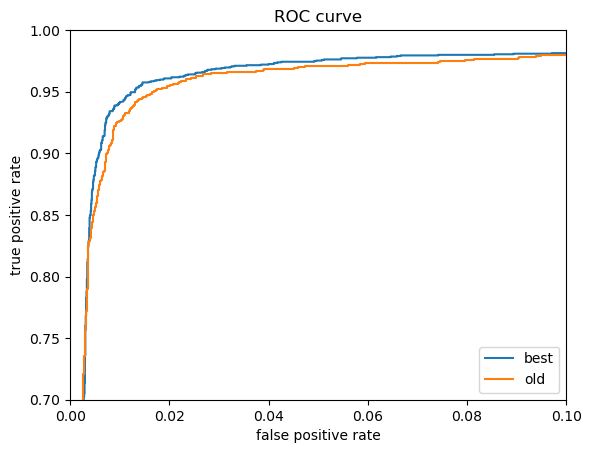

In [51]:
from sklearn.metrics import roc_curve
    
with torch.no_grad():
    logits = model(X_test)
    y_prob_ = torch.sigmoid(logits).numpy().flatten()
    
fpr_, tpr_, thresh_ = roc_curve(y_test, y_prob_)

fig = plt.figure()
ax1 = plt.subplot()

ax1.plot(fpr_, tpr_, label='best')
ax1.plot(fpr, tpr, label='old')

ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('ROC curve')
ax1.set_xlim(0,0.1)
ax1.set_ylim(0.7,1)
plt.legend()

plt.show()

The ROC curve with the optimal parameters is a little bit closer to the top left corner than the previous one. Let's see how it improves the classification with respect to the other methods.

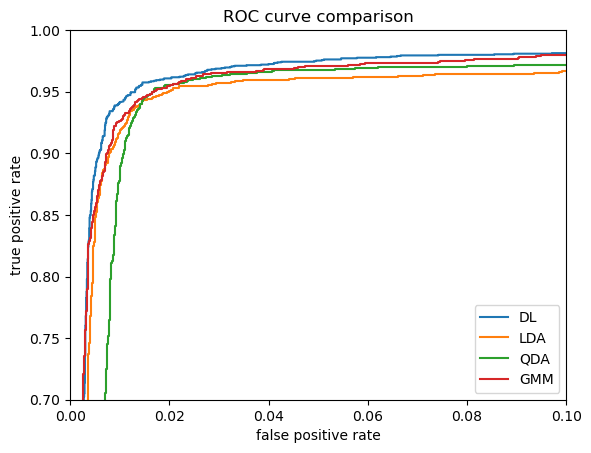

In [53]:
# Plot ROC curves 

fig = plt.figure()
ax1 = plt.subplot()

ax1.plot(fpr_, tpr_, label='DL')

fpr, tpr, thresh = roc_curve(y_test, probLDA)
ax1.plot(fpr, tpr, label='LDA')

fpr, tpr, thresh = roc_curve(y_test, probQDA)
ax1.plot(fpr, tpr, label='QDA')

fpr, tpr, thresh = roc_curve(y_test, probGMM)
ax1.plot(fpr, tpr, label='GMM')

ax1.set_xlim(0, 0.1)
ax1.set_ylim(0.7, 1)

ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('ROC curve comparison')
ax1.legend(loc=4)

plt.show()